# **Deep Reinforcement Learning Route Finder**

Here in this jupyter notebook, we will have some fun with using reinforcement learning to find safe routes across the ice.
This notebook draws a lot of inspiration from Open AI's [FrozenLake](https://gym.openai.com/envs/FrozenLake8x8-v0/) gym environment.
Really, how nice of them to have a well crafted toy problem already thought out for us!

Specifically and technically, we will train an actor-critic based model in Keras/Tensorflow to help us decide safe routes across slippery ice!
Later, we will move on to applying this safe navigation tool to our crevasse avoidance problem.

References:
- Open AI [gym](https://github.com/openai/gym) 
- [Simple Reinforcement Learning with Tensorflow Part 0: Q-Learning with Tables and Neural Networks](https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-0-q-learning-with-tables-and-neural-networks-d195264329d0)
- [Simple Reinforcement Learning with Tensorflow Part 4: Deep Q-Networks and Beyond](https://medium.com/@awjuliani/simple-reinforcement-learning-with-tensorflow-part-4-deep-q-networks-and-beyond-8438a3e2b8df)
- [Frozen Lake github gist using Keras](https://gist.github.com/ceshine/eeb97564c21a77b8c315179f82b3fc08)
- [Reinforcement Learning w/ Keras + OpenAI: DQNs](https://towardsdatascience.com/reinforcement-learning-w-keras-openai-dqns-1eed3a5338c)
- [Introduction to Various Reinforcement Learning Algorithms. Part I (Q-Learning, SARSA, DQN, DDPG)](https://towardsdatascience.com/introduction-to-various-reinforcement-learning-algorithms-i-q-learning-sarsa-dqn-ddpg-72a5e0cb6287)
- [Actor Critic with OpenAI Gym](http://www.rage.net/~greg/2016-07-05-ActorCritic-with-OpenAI-Gym.html)

In [1]:
# Import all the necessary libraries
import os
import random
import shutil
import sys
import warnings
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "2"  #set to see only the 3rd gpu
os.environ['KERAS_BACKEND'] = 'tensorflow'
warnings.simplefilter(action = "ignore", category = FutureWarning)

import multiprocessing
import threading

import affine
import math
import matplotlib.pyplot as plt
import matplotlib.patches
import numpy as np
import rasterio
import scipy.spatial
import scipy.stats
%matplotlib inline

import gym
from gym.utils import seeding
import quilt

import keras
import tensorflow as tf
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Conv2D, Flatten, Dense, Input, Concatenate
from keras.layers.core import Activation, Flatten, Dropout, Reshape
from keras.callbacks import TensorBoard

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Keras        :', keras.__version__)
print('Scipy        :', scipy.__version__)
print('Tensorflow   :', tf.__version__)
tf.test.gpu_device_name()

Using TensorFlow backend.


Python       : 3.6.5 | packaged by conda-forge | (default, Apr  6 2018, 13:39:56) 
Numpy        : 1.14.2
Keras        : 2.1.5
Scipy        : 1.0.1
Tensorflow   : 1.6.0


'/device:GPU:0'

In [2]:
# Set seed values
seed = 42
random.seed = seed
np.random.seed(seed=seed)
tf.set_random_seed(seed=seed)

### Load map grid environment (the crevasse laden terrain our virtual player will be crossing) from quilt

In [3]:
quilt.install(package='weiji14/nz_space_challenge', hash='706b30f3', force=True)

100%|██████████| 490M/490M [00:00<00:00, 63.5GB/s]

(3616, 7200, 1)


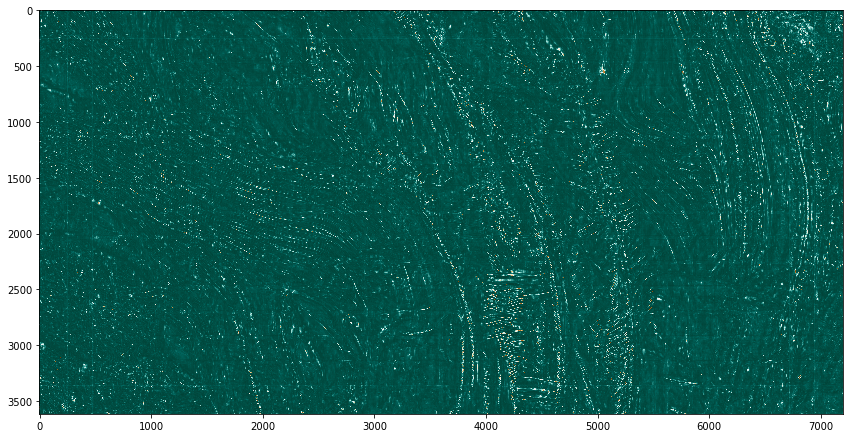

In [4]:
from quilt.data.weiji14 import nz_space_challenge
with rasterio.open(fp=nz_space_challenge.intertrain.crevasse_map()) as raster_source:
    map_env = raster_source.read(indexes=list(range(1,raster_source.count+1)), masked=True)  #outputs a masked numpy array of shape (1, height, width)
    map_env = np.rollaxis(a=map_env, axis=0, start=3)   #change to shape (height, width, 1)
    print(map_env.shape)
    transform = raster_source.transform  #affine transformation to convert between image and geographic coordinates

fig, axarr = plt.subplots(nrows=1, ncols=1, squeeze=False, figsize=(14.4,9.6))
axarr[0, 0].imshow(-map_env[:,:,0], cmap='BrBG')

# CrevasseCrosser gym environment

## Implement our own CrevasseCrosser class based on OpenAI FrozenLake gym

Borrows some elements from https://github.com/openai/gym/blob/master/gym/envs/toy_text/frozen_lake.py

**Note**: There are a lot of Python classes wrapping functions to implement this CrevasseCrosserEnv (read: can be hard to follow if you're not familiar with the OpenAI gym). If you are looking for the previous pure numpy implementation that more clearly illustrates the mechanics, you can check out an older version at this [git commit](https://github.com/weiji14/nz_space_challenge/blob/11c293a1c30029b4717c0e40111c56f047dea3c0/route_finder.ipynb).

In [5]:
#https://stackoverflow.com/questions/45068568/is-it-possible-to-create-a-new-gym-environment-in-openai/47132897#47132897
class CrevasseCrosserEnv(gym.Env):
    """
    An OpenAI gym compatible custom environment inspired from the FrozenLake env!
    
    The map should be a 2D numpy array, with values on each xy position indicating the
    penalty for stepping on to that position. The centre pixels, specifically a 2x2 square,
    will be where our player is assumed to be located. Moving around the map environment 
    is done using a scrolling method, similar to classic RPG games! Not sure if I explained
    this intuitively enough :P
    
    Anyways, E.g. if values range from 0 to 1
    Values close to '1' would indicate a hole or 'H' in the FrozenLake env
    Values close to '0' would indicate the goal or 'G' in the FrozenLake env
    Values in between '0.25-0.75' would be the free spot or 'F' in the FrozenLake env, note that we penalize steps!
    There is not really a starting point 'S', we always assume the player is in the centre
    """
    
    def __init__(self, map_env:np.ndarray=None, observation_window:tuple=(128,128,1),
                 transform:affine.Affine=None, start_xy:tuple=None, end_xy:tuple=None):
        
        self.map_env = map_env
        assert(isinstance(self.map_env, np.ndarray))  #check that we are passing in a numpy array
        assert(map_env.ndim==3)  #check that we have a map_env of shape (height, width, channels)
                
        self.observation_window = observation_window
        assert(len(self.observation_window) == 3)  #check that we have a observation window of shape (height, width, channels)
        assert(self.observation_window[0]%2 == 0)  #check that our observation window height is an even number
        assert(self.observation_window[1]%2 == 0)  #check that our observation window width is an even number
        
        self.map_env_shape = self.map_env.shape    #create an alias to the map_env shape
        assert(self.map_env_shape[-1] == self.observation_window[-1])  #check that the no. of channels in our map_env matches the no. of channels in our observation_window
        assert(self.map_env_shape[-1] == 1)  #check that we only have a one band/channel input, TODO remove when moving to more bands!
        
        self.info = None      #dictionary to store geographic coordinates of our player
        self.gameover = None  #setting to store whether game round is over
        self.total_steps = 0  #store a counter of steps taken by the player
        self.centrepoint = {'pixel_midy':None, 'pixel_midx': None}  #initialize this observation centrepoint variable

        ## number of Actions (discrete)
        ## Define what our agent can do, i.e. move left, down, right, up
        self.nA = 4
        self.action_space = gym.spaces.Discrete(self.nA)
        
        self.transform = transform
        self.start_xy = start_xy
        self.end_xy = end_xy
        
        self.current_observation = self.reset()    #reset our current observation to a random or designated initial state
        
        if self.start_xy is not None or self.end_xy is not None:
            assert(self.transform is not None)     #check that affine transform is available, so coordinates can be converted!!
            if self.start_xy is not None:
                assert(len(self.start_xy) == 2)    #check that we are passing in 2 numbers (x_coordinate, y_coordinate)
            if self.end_xy is not None:
                assert(len(self.end_xy) == 2)      #check that we are passing in 2 numbers (x_coordinate, y_coordinate)
                self.geodist_to_goal = scipy.spatial.distance.euclidean(u=(self.centrepoint['geo_midx'], self.centrepoint['geo_midy']),
                                                                        v=self.end_xy)
        
    def reset(self):
        """
        Function to reset the entire environment
        
        if self.start_xy is None:
            Set our player at some random place on the map
        elif self.start_xy is (x_coord, y_coord):
            Set our player at the designated place
        """
        self.info = None
        self.gameover = False
        self.lastaction = None
        self.total_steps = 0
        
        ## Get random x and y positions (image coordinates) from the map_env that are not too close to the border
        if self.start_xy is None:
            pixel_midy = np.random.randint(low=0+2*self.observation_window[0],
                                           high=self.map_env.shape[0]-2*self.observation_window[0])
            pixel_midx = np.random.randint(low=0+2*self.observation_window[1],
                                           high=self.map_env.shape[1]-2*self.observation_window[1])
        else:
            pixel_midy, pixel_midx = rasterio.transform.rowcol(transform=self.transform,
                                                               xs=self.start_xy[0], ys=self.start_xy[1],
                                                               op=math.ceil)  #math.ceil rounds to bottom right in image coords
            assert(0 <= pixel_midy < self.map_env.shape[0])  #check (roughly) that our y is within the map environment
            assert(0 <= pixel_midx < self.map_env.shape[1])  #check (roughly) that our x is within the map environment
        
        self.current_observation, self.centrepoint = self.set_observation(pixel_midy=pixel_midy, pixel_midx=pixel_midx)
        
        return self.current_observation  #return initial observation
    
    
    def set_observation(self, pixel_midy:int, pixel_midx:int):
        """
        Crop a 2D slice out of our map environment given an input midpoint
        Note that the midpoint should reference the bottom right corner
        of the pixel, so that the array slicing method will be correct!!
        """
        pixel_y0 = pixel_midy - int(self.observation_window[0]/2)
        pixel_y1 = pixel_midy + int(self.observation_window[0]/2)
        pixel_x0 = pixel_midx - int(self.observation_window[1]/2)
        pixel_x1 = pixel_midx + int(self.observation_window[1]/2)
        
        observation = self.map_env[pixel_y0:pixel_y1,
                                   pixel_x0:pixel_x1, :]
        try:
            assert(observation.shape == self.observation_window)  #check that obsevation is within map environment!
        except:
            print(f"{observation.shape} is less than {self.observation_window}")
            raise
        
        centrepoint = {'pixel_midy': pixel_midy, 'pixel_midx': pixel_midx}
        
        if self.transform is not None:
            geo_midx, geo_midy = rasterio.transform.xy(transform=self.transform,
                                                       cols=pixel_midx,
                                                       rows=pixel_midy,
                                                       offset='lr')  #convert image coordinates to geographic coordinates
            centrepoint.update({'geo_midy': geo_midy, 'geo_midx': geo_midx})
        
        return observation, centrepoint
    
    
    def step(self, action):
        """
        Moves our player around the environment by applying an action
        
        Returns:
        (observation, reward, done, info)
        """
        if self.gameover == True:
            return (self.current_observation, 0, True, {})
        
        ## Get new OBSERVATION after making an action
        new_pixel_midy = self.centrepoint['pixel_midy']
        new_pixel_midx = self.centrepoint['pixel_midx']
        
        #try:
        #    assert(isinstance(action, int))  #used for standard dqn where action is an integer
        #except AssertionError:
        #    action = np.argmax(a=action)  #used for actor-critic environment where action is a list of probs
        
        if action == 0: #Left <-
            if new_pixel_midx - self.observation_window[1]/2 - 2 > 0:
                new_pixel_midx -= 2
                self.total_steps += 1
        elif action == 1: #Down v
            if new_pixel_midy + self.observation_window[0]/2 + 2 < self.map_env_shape[0]:
                new_pixel_midy += 2
                self.total_steps += 1
        elif action == 2: #Right ->
            if new_pixel_midx + self.observation_window[1]/2 + 2 < self.map_env_shape[1]:
                new_pixel_midx += 2
                self.total_steps += 1
        elif action == 3: # Up ^
            if new_pixel_midy - self.observation_window[0]/2 - 2 > 0:
                new_pixel_midy -= 2
                self.total_steps += 1
        
        self.current_observation, self.centrepoint = self.set_observation(pixel_midy=new_pixel_midy,
                                                                          pixel_midx=new_pixel_midx)
        
        ## Get REWARD from centre 2x2 grid square
        '''     0 , 10 , 20 , 30 , 40 , 50 , 60 , 70 , 80 , 90 , 100 = percentiles
                          |             |              |                  
             <- good goal |        free median         | bad hole->               
        reward:        +1 |             0              | -1                    '''
        
        midsquare_vals = self.map_env[self.centrepoint['pixel_midy']-1:self.centrepoint['pixel_midy']+1,
                                      self.centrepoint['pixel_midx']-1:self.centrepoint['pixel_midx']+1, :]
        midsquare_max = np.max(midsquare_vals)  #get maximum of the midsquare pixels
        percentileofscore = scipy.stats.percentileofscore(a=self.current_observation.ravel(),
                                                          score=midsquare_max)  #find percentile of midsquare_max
        midsquare_rank = 10 * int(math.floor(percentileofscore/10.0))  #rank from 0 (good goal) to 100 (bad hole)
        assert(midsquare_rank % 10 == 0)
        
        G, C, F, H = (+1, 0, 0, -1)  #rewards corresponding to Goal, Close, Free, Hole
        reward = [G,G,G,F,F,F,F,F,H,H,H][midsquare_rank//10]  #use python indexing to get base reward
        #print(midsquare_rank, reward)
        
        ## Get DONE (or not) status 
        if midsquare_rank >= 80:  #i.e. if we're in a crevasse!
            done = self.gameover = True
        else:
            if self.end_xy is None:  #when we don't have a set endpoint
                if midsquare_rank > 20 and midsquare_rank < 80: #if in a free spot
                    done = False
                elif midsquare_rank <= 20:  #i.e. we've reached the goal!
                    #difficulty = np.sum(self.current_observation)  #sum of all the pixels give indication of difficulty of map
                    #bonus = (difficulty/np.product(a=self.observation_window)) * 50  #modulate the bonus with size of observation_window
                    #reward += bonus  #give a bonus of a few points related to difficulty of the map
                    done = self.gameover = True

            elif self.end_xy is not None:  #when we have set an endpoint
                geo_resolution = self.transform.a  #equal to self.transform[0], assuming x and y resolution are the same
                new_geodist_to_goal = scipy.spatial.distance.euclidean(u=(self.centrepoint['geo_midx'], self.centrepoint['geo_midy']),
                                                                       v=self.end_xy)
                if new_geodist_to_goal < geo_resolution:  #when we are within the spatial resolution of the endpoint
                    bonus = 10   #arbitrarily large bonus for reaching the goal
                    reward += bonus
                    done = self.gameover = True
                elif new_geodist_to_goal >= geo_resolution:  #when we are still somewhat far from our goal
                    delta_dist = new_geodist_to_goal - self.geodist_to_goal  #new distance to goal minus old distance to goal
                    bonus = (-delta_dist/geo_resolution)*F  #negative delta_dist normalized by spatial resolution and free spot reward
                    reward += bonus
                    done = False           
                self.geodist_to_goal = new_geodist_to_goal
            
    
        ## Get INFO about coordinates of midpoint
        if self.transform is not None:
            self.info = {'total_steps': self.total_steps}
            self.info.update({'geo_x': self.centrepoint['geo_midx'], 'geo_y': self.centrepoint['geo_midy']})
            if self.end_xy is not None:
                self.info.update({'geodist_to_goal': self.geodist_to_goal})
        else:            
            self.info = {'total_steps': self.total_steps, 'geo_x': None, 'geo_y': None}

        self.lastaction = action
        return (self.current_observation, reward, done, self.info)
    
    
    def render(self, mode='human'):
        """
        Matplotlib function to plot the current observation window
        with the player position in the middle as a 2x2 grid box
        """
        fig, axarr = plt.subplots(nrows=1, ncols=1, squeeze=False, figsize=(5,5))
        #axarr[0, 0].imshow(X=self.player_position[:,:,0], cmap='winter')
        axarr[0, 0].imshow(X=-self.current_observation[:,:,0], cmap='BrBG')
        upper_left_y = self.observation_window[0]/2 - 1 - 0.5 
        upper_left_x = self.observation_window[1]/2 - 1 - 0.5
        axarr[0, 0].add_patch(matplotlib.patches.Rectangle(xy=(upper_left_x,upper_left_y),
                                                           width=2,
                                                           height=2,
                                                           fill=False,
                                                           edgecolor='red',
                                                           linewidth=2))
        
        if self.lastaction is not None:
            actionTaken = ["Left","Down","Right","Up"][self.lastaction]
            print(f"  ({actionTaken}, {self.info})")
        else:
            print("")
        return plt.show()
    
    
    def seed(self, seed=None):
        """
        Just a simple function to set the seed of our gym environment
        """
        self.np_random, seed = gym.utils.seeding.np_random(seed=seed)
        return [seed]

## Have a play with our gym environment

In [6]:
observation_window = (128,128,1)
#env = CrevasseCrosserEnv(map_env=map_env, observation_window=observation_window, transform=transform)
env = CrevasseCrosserEnv(map_env=map_env, observation_window=observation_window, transform=transform, start_xy=(2800,-904550), end_xy=(12093,-881519))  #
env.seed(seed=seed)

[42]

  (Left, {'total_steps': 1, 'geo_x': 2737.5, 'geo_y': -904737.5, 'geodist_to_goal': 25032.461375182425})


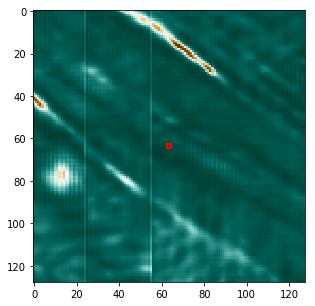

observation 1.0 False {'total_steps': 1, 'geo_x': 2737.5, 'geo_y': -904737.5, 'geodist_to_goal': 25032.461375182425}


In [7]:
#Unit tests
env.reset()
observation, reward, done, info = env.step(env.action_space.sample())
env.render()
print('observation', reward, done, info)

# A3C (Asynchronous Advantage Actor-Critic) Agent!!

(Near) State of the art way for training an agent to move around in an environment. The implementation here is for a discrete space only (i.e. moving left, down, right or up).

References:

- [Reinforcement Learning w/ Keras + OpenAI: Actor-Critic Models](https://towardsdatascience.com/reinforcement-learning-w-keras-openai-actor-critic-models-f084612cfd69) - Great starting overview and ipynb implementation
- [Let’s make an A3C: Implementation](https://jaromiru.com/2017/03/26/lets-make-an-a3c-implementation/) - Best technical explaination  of the maths
- [Deep Reinforcement Learning Flappy Bird](https://shalabhsingh.github.io/Deep-RL-Flappy-Bird/) - Good reference keras implementation
- [Asynchronous Advantage Actor-Critic (A3C) (Tensorflow)](https://morvanzhou.github.io/tutorials/machine-learning/reinforcement-learning/6-3-A3C/) - Nice video (in Chinese) and very well structured tensorflow implementation!!!
- [Intuitive RL: Intro to Advantage-Actor-Critic (A2C)](https://hackernoon.com/intuitive-rl-intro-to-advantage-actor-critic-a2c-4ff545978752) - A non-asynchronous version to get your head around first
- [Asyncronous RL in Tensorflow + Keras + OpenAI's Gym](https://github.com/coreylynch/async-rl) - Another pretty awesome keras implementation

Disambiguation table?

|   Name  |  Outputs | Meaning              |
| ------- |----------|----------------------|
|  Actor  |  Policy  | action probabilities |
| Critic  |  Value   | value of being in an observation state |

In [8]:
class ActorCritic_Network(object):
    """
    This class can turn into the master global Actor-Critic network,
    or it can become one of the minion worker Actor-Critic networks.
    Basically, this is a reusable class that forms our reinforcement
    learning deep neural network's brain.
    """
    
    def __init__(self, scope:str=None , globalAC=None,
                 state_shape:tuple=(128,128,1), action_size:int=4,
                 tensorflow_session=None):
        """
        Here we build the keras/tensorflow computational graph
        """
        
        self.scope = scope  #either 'Global_Net' or 'Worket_Net_(i)'
        self.state_shape = state_shape  #input observation state shape
        self.action_size = action_size
        self.tensorflow_session = tensorflow_session
        
        if scope == 'Global_Net':
            """The boss has a simple graph but not much else"""
            with K.tf.variable_scope(name_or_scope='Global_Net'):
                self.state = K.tf.placeholder(dtype=tf.float32, shape=(None,)+self.state_shape, name='state')
                _, _, self.actor_params, self.critic_params = self._build_net(scope=self.scope)
        elif 'Worker_Net' in scope:
            """The minions have a lot of stuff to declare..."""
            print(f"Spawned {scope}")
            with K.tf.variable_scope(name_or_scope=self.scope):
                self.state = K.tf.placeholder(dtype=tf.float32, shape=(None,)+self.state_shape, name='state')             #shape (?,128,128,1)
                self.action = K.tf.placeholder(dtype=tf.int32, shape=(None,), name='action')                              #shape (?,) ??(?,4)??
                self.critic_value_target = tf.placeholder(dtype=tf.float32, shape=(None, 1), name='critic_value_target')  #shape (?,1)
                
                self.actor_output, self.critic_output, self.actor_params, self.critic_params = self._build_net(scope=self.scope)
                
                td = K.tf.subtract(x=self.critic_value_target, y=self.critic_output, name='TD_error')
                #print(td)
                with K.tf.name_scope('critic_loss'):
                    self.critic_loss = K.mean(K.square(td))  #value loss
                
                with K.tf.name_scope('actor_loss'):
                    log_prob = K.sum(x=(K.log(self.actor_output)*K.one_hot(indices=self.action, num_classes=self.action_size)),
                                     axis=1, keepdims=True)
                    exp_v = log_prob * K.stop_gradient(variables=td)
                    entropy = -K.sum(x=(self.actor_output * K.log(self.actor_output + K.epsilon())), axis=1, keepdims=True)
                    
                    self.exp_v = K.epsilon() * entropy + exp_v
                    self.actor_loss = K.mean(x=-self.exp_v)  #policy loss
                
                with K.tf.name_scope('local_gradients'):
                    self.actor_gradients = K.gradients(loss=self.actor_loss, variables=self.actor_params)
                    self.critic_gradients = K.gradients(loss=self.critic_loss, variables=self.critic_params) 
                
            with K.tf.name_scope(name='sync'):
                """
                l_p is local_parameter from Worker_Net_(i)
                g_p is global parameter from Global_Net
                """
                with K.tf.name_scope('pull'):
                    #operation to pull or download params from global network
                    self.pull_actor_params_op = [l_p.assign(g_p) for l_p, g_p in zip(self.actor_params, globalAC.actor_params)]
                    self.pull_critic_params_op = [l_p.assign(g_p) for l_p, g_p in zip(self.critic_params, globalAC.critic_params)]
                with K.tf.name_scope('push'):
                    #operation to push or upload params to global network
                    optimizer = K.tf.train.RMSPropOptimizer(learning_rate=0.001)
                    self.push_actor_params_op = optimizer.apply_gradients(grads_and_vars=zip(self.actor_gradients, globalAC.actor_params))
                    self.push_critic_params_op = optimizer.apply_gradients(grads_and_vars=zip(self.critic_gradients, globalAC.critic_params))
        else:
            raise ValueError(f"Unknown scope {self.scope}, should be either Global_Net or Worker_Net_(i)")
            
    def _build_net(self, scope:str):
        '''
        This is where we build the actor-critic models.
        Note that the actor and critic both share the first few conv and dense layers,
        only in the last layer do we split off into actor and critic output dense layers
        '''
        k_init = keras.initializers.RandomUniform(minval=-0.1, maxval=0.1)
        with K.tf.variable_scope('actor_critic_shared_conv_layers'):
            inp = Input(tensor=self.state)
            assert(inp.shape.ndims == 4)  #needs to be shape like (?,4,4,1) for 4x4 grid, (?,8,8,1) for 8x8 grid
            X = Conv2D(filters=16, kernel_size=(8,8), strides=(4,4), kernel_initializer=k_init, activation='relu')(inp)
            X = Conv2D(filters=32, kernel_size=(4,4), strides=(2,2), kernel_initializer=k_init, activation='relu')(X)
            X = Flatten()(X)
            X = Dense(units=256, kernel_initializer=k_init, activation='relu')(X)
        
        #Actor's Policy output (probability of taking each possible action)
        with K.tf.variable_scope('actor_output'):
            actor_output = Dense(units=4, kernel_initializer=k_init, activation='softmax', name='actor_output')(X)
            
        #Critic's Value output (how good it is to be in this current observation state)
        with K.tf.variable_scope('critic_output'):
            critic_output = Dense(units=1, kernel_initializer=k_init, activation='linear', name='critic_output')(X)
        
        self.actor_model = Model(inputs=inp, outputs=actor_output)
        self.critic_model = Model(inputs=inp, outputs=critic_output)
        
        actor_params = self.actor_model.trainable_weights
        critic_params = self.critic_model.trainable_weights

        return actor_output, critic_output, actor_params, critic_params
    
    def push_global(self, feed_dict:dict):
        """Pushing things from local Worker_Net up to Global_Net, run by a worker only"""
        self.tensorflow_session.run(fetches=[self.push_actor_params_op, self.push_critic_params_op], feed_dict=feed_dict)
        
    def pull_global(self):
        """Pulling things from Global_Net down to local Worker_Net, run by a worker only"""
        self.tensorflow_session.run(fetches=[self.pull_actor_params_op, self.pull_critic_params_op])
    
    def choose_action(self, state, choose_random:bool=True):
        """Given a state observation, we choose an action to perform, run by a worker only"""
        prob_weights = self.tensorflow_session.run(fetches=self.actor_output, feed_dict={self.state: state[np.newaxis, :]})
        if choose_random == True:
            action = np.random.choice(a=range(prob_weights.shape[1]), p=prob_weights.ravel())  #select action w.r.t the actions prob
            return action
        elif choose_random == False:
            action = np.argmax(prob_weights)  #select the best action
            return action, prob_weights

In [9]:
class ActorCritic_Worker(object):
    """
    This class puts the actor-critic worker models to work!
    """
    def __init__(self, name:str, globalAC, env, tensorflow_session):
        
        self.env = env
        self.name = name
        self.AC = ActorCritic_Network(scope=name, globalAC=globalAC, tensorflow_session=tensorflow_session)
        self.tensorflow_session = tensorflow_session
    
    def work(self, num_episodes=100000):
        global GLOBAL_RUNNING_R, GLOBAL_EP
        total_step = 1
        buffer_s, buffer_a, buffer_r = [], [], []   #initialize memory buffer to store 'state', 'action', 'reward'
        
        while not COORDINATER.should_stop() and GLOBAL_EP < num_episodes:
            current_state = self.env.reset()
            episode_reward = 0
            while True:
                action = self.AC.choose_action(state=current_state)
                future_state, reward, done, info = self.env.step(action=action)
                #if done: r = -5
                episode_reward += reward
                buffer_s.append(current_state[np.newaxis, :])
                buffer_a.append(action)
                buffer_r.append(reward)
                
                #TODO make more readable
                if total_step % 32 == 0 or done==True: # push to global every 32 steps and pull params to local worker net
                    if done==True:
                        critic_value_ = 0   # terminal gameover state
                    else:
                        critic_value_ = self.tensorflow_session.run(fetches=self.AC.critic_output,
                                                                    feed_dict={self.AC.state: future_state[np.newaxis, :]})[0, 0]  #predicted critic value
                    buffer_v_target = []
                    for rew in buffer_r[::-1]:    # reverse buffer reward, stepping back in time, i.e. new --> old
                        critic_value_ = rew + 0.99 * critic_value_  #Gamma set a 0.99, here we recursively update the value of the state predicted by the critic
                        buffer_v_target.append(critic_value_)
                    buffer_v_target.reverse()   #reverse buffer list in place, so is old --> new
                    
                    buffer_s, buffer_a, buffer_v_target = np.vstack(buffer_s), np.array(buffer_a), np.vstack(buffer_v_target)
                    feed_dict = {
                                self.AC.state: buffer_s,
                                self.AC.action: buffer_a,
                                self.AC.critic_value_target: buffer_v_target,
                                }
                    
                    self.AC.push_global(feed_dict=feed_dict)    #push gradient updates from this local Worker_Net to master Global_Net
                    buffer_s, buffer_a, buffer_r = [], [], []   #reset our memory buffer 
                    self.AC.pull_global()                       #pull gradient updates from master Global_Net to this local Worker_Net
                
                current_state = future_state  #the future has arrived!
                total_step += 1
                
                if done==True:
                    # record running episode reward
                    try:
                        GLOBAL_RUNNING_R.append(0.9 * GLOBAL_RUNNING_R[-1] + 0.1 * episode_reward)  #calculate running episode_reward ??
                    except IndexError:                           #if len(GLOBAL_RUNNING_R) == 0
                        GLOBAL_RUNNING_R.append(episode_reward)  #add episode_reward to global list
                        
                    
                    if GLOBAL_EP % (num_episodes/10) == 0:  #print text info every 1/10 of global episodes
                        print(
                            self.name,
                            f"Episode: {GLOBAL_EP}",
                            f"| Running_Episode_reward: {GLOBAL_RUNNING_R[-1]}",
                              )
                        #K.tf.summary.scalar(name='running_reward', tensor=[0.9 * GLOBAL_RUNNING_R[-1] + 0.1 * episode_reward])
                        #summary_op = K.tf.merge_all_summaries()
                        
                        #if GLOBAL_EP % 100 == 0:  #print plot every 100 global episodes
                        #    plt.plot(np.arange(start=len(GLOBAL_RUNNING_R)-100, stop=len(GLOBAL_RUNNING_R)), GLOBAL_RUNNING_R[-100:])
                        #    plt.xlabel('step')
                        #    plt.ylabel('Total moving reward')
                        #    plt.show()
                        
                    GLOBAL_EP += 1
                    break

## **Train the Actor-Critic model here**

In [10]:
GLOBAL_RUNNING_R = []
GLOBAL_EP = 0

if __name__ == '__main__':
    SESS = tf.Session()
    
    #with K.tf.device("/cpu:0"):
    with K.tf.device("/gpu:0"):
        globalAC = ActorCritic_Network(scope='Global_Net', tensorflow_session=SESS)
        
        observation_window = (128,128,1)
        env = CrevasseCrosserEnv(map_env=map_env, observation_window=observation_window, transform=transform)
        
        #spawn 16 workers!! Use multiprocessing.cpu_count() to see how many cpus available, or don't care if gpu available?
        workers = [ActorCritic_Worker(name=f'Worker_Net_{i:03}', globalAC=globalAC, env=env, tensorflow_session=SESS) for i in range(16)]
        
        COORDINATER = K.tf.train.Coordinator()         #a tensorflow coordinater for threads
        SESS.run(K.tf.global_variables_initializer())  #initialize global variables for tensorflow
        
        if True==True:   #Set to True==True if we want to output a graph
            #if os.path.exists(path='model/logs/a3c'):
            #    shutil.rmtree(path='model/logs/a3c')
            K.tf.summary.FileWriter(logdir='model/logs/a3c', graph=SESS.graph)
        
        worker_threads = []                  #list to store all the worker threads
        for worker in workers:
            job = lambda: worker.work(num_episodes=10000)   #function that calls the worker to work
            t = threading.Thread(target=job)               #put the minion worker to work in a thread!
            t.start()
            worker_threads.append(t)         #append worker thread into our list
        COORDINATER.join(worker_threads)     #use our tensorflow coordinator to coordinate the worker threads

Spawned Worker_Net_000
Spawned Worker_Net_001
Spawned Worker_Net_002
Spawned Worker_Net_003
Spawned Worker_Net_004
Spawned Worker_Net_005
Spawned Worker_Net_006
Spawned Worker_Net_007
Spawned Worker_Net_008
Spawned Worker_Net_009
Spawned Worker_Net_010
Spawned Worker_Net_011
Spawned Worker_Net_012
Spawned Worker_Net_013
Spawned Worker_Net_014
Spawned Worker_Net_015
Worker_Net_002 Episode: 0 | Running_Episode_reward: 0
Worker_Net_012Worker_Net_006 Episode: 1000 | Running_Episode_reward: -0.09275193388809537
 Episode: 1000 | Running_Episode_reward: 0.008053406791005155
Worker_Net_014Worker_Net_008 Episode: 2000 Episode: 2000 | Running_Episode_reward: -0.560034803469174
 | Running_Episode_reward: -0.5040313231222566
Worker_Net_003 Episode: 3000 | Running_Episode_reward: -0.12155549124046998
Worker_Net_005Worker_Net_006Worker_Net_007 Episode: 3000 | Running_Episode_reward: -0.08861395311430262
 Episode: 3000 | Running_Episode_reward: -0.10939994211642298
 Episode: 3000 | Running_Episode_re

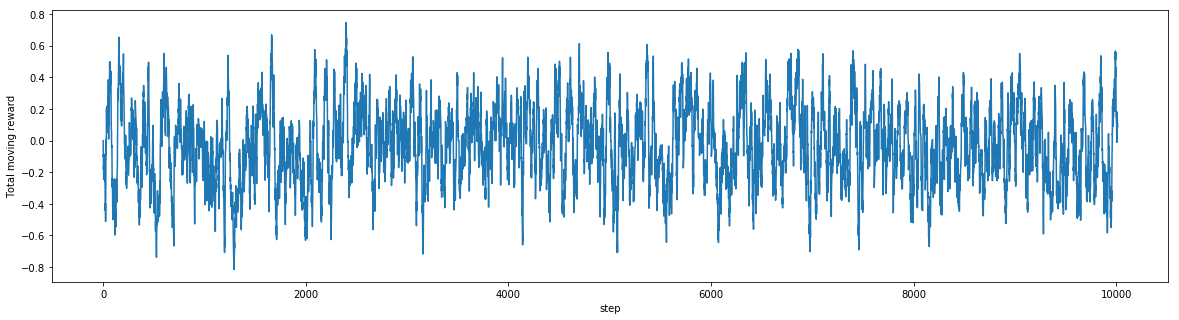

In [11]:
# Plot running average of reward over time?
plt.figure(figsize=(20,5))
plt.plot(np.arange(len(GLOBAL_RUNNING_R)), GLOBAL_RUNNING_R)
plt.xlabel('step')
plt.ylabel('Total moving reward')
plt.show()

## Save the Route Navigator actor model!

We only save the actor model that gives action probability outputs.

In [12]:
navigator_agent = workers[0].AC.actor_model  #just choose the first worker's actor model
navigator_agent.save_weights(filepath='model/weights/navigator-actor-model-weights.hdf5')

# Final evaluation of route navigator model

### See how our player does

In [13]:
navigator_agent.load_weights(filepath='model/weights/navigator-actor-model-weights.hdf5')  #reload the saved dqn model weights

In [14]:
env = CrevasseCrosserEnv(map_env=map_env, observation_window=observation_window, transform=transform)
env = CrevasseCrosserEnv(map_env=map_env, observation_window=observation_window, transform=transform, start_xy=(2800,-904550), end_xy=(12093,-881519))  #
env.seed(seed=seed)

[42]

0 [[0.26763687 0.23262407 0.26043746 0.23930165]] 1.0 False
  (Left, {'total_steps': 1, 'geo_x': 2737.5, 'geo_y': -904737.5, 'geodist_to_goal': 25032.461375182425})


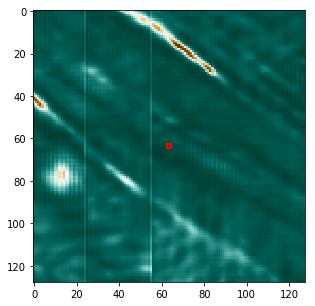

0 [[0.26763687 0.23262407 0.26043746 0.23930165]] 1.0 False
0 [[0.26763687 0.23262407 0.26043746 0.23930165]] 1.0 False
  (Left, {'total_steps': 3, 'geo_x': 2237.5, 'geo_y': -904737.5, 'geodist_to_goal': 25223.592577188523})


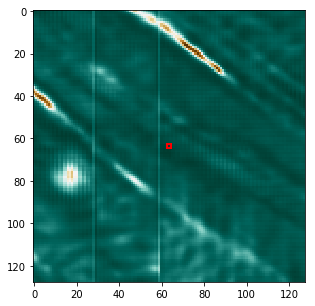

0 [[0.26763687 0.23262407 0.26043746 0.23930165]] 1.0 False
0 [[0.26763687 0.23262407 0.26043746 0.23930165]] -1 True
  (Left, {'total_steps': 5, 'geo_x': 1737.5, 'geo_y': -904737.5, 'geodist_to_goal': 25322.319650853475})


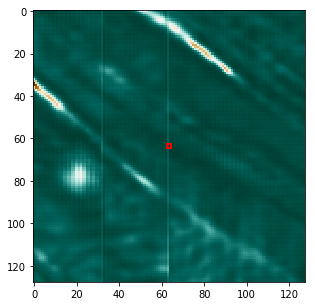

Done!


In [15]:
observation = env.reset()
for i in range(32):
    action, action_probs = workers[0].AC.choose_action(state=observation, choose_random=False)  #TEMP hack to get action probs
    #TODO make the below two lines work instead of hack above...
    #action_probs = navigator_agent.predict(x=observation[np.newaxis, :], batch_size=1)  
    #action = np.argmax(action_probs)  #select the best action
    
    observation, reward, done, info = env.step(action=action)
    print(action, action_probs, reward, done)
    if i%2==0:
        env.render()#, plt.imshow(observation[60:68,60:68,0])
    if done:
        print('Done!')
        break